# Классификация комментариев по работе управляющей компании

Этот ноутбук предназначен для разработки и обучения модели машинного обучения для классификации комментариев пользователей по различным категориям, связанным с работой управляющей компании.


In [31]:
!pip uninstall torch -y
!pip install torch


Found existing installation: torch 2.7.0
Uninstalling torch-2.7.0:
  Successfully uninstalled torch-2.7.0
  Using cached torch-2.7.0-cp312-cp312-win_amd64.whl.metadata (29 kB)
Using cached torch-2.7.0-cp312-cp312-win_amd64.whl (212.5 MB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.7.0+cu118 requires torch==2.7.0+cu118, but you have torch 2.7.0 which is incompatible.
torchvision 0.22.0+cu118 requires torch==2.7.0+cu118, but you have torch 2.7.0 which is incompatible.


In [ ]:
import torch

AttributeError: module 'torch' has no attribute 'version'

In [36]:
# Установка библиотек
!pip install torch==2.4.0 transformers==4.39.3 --upgrade --force-reinstall
import pandas as pd
import numpy as np
import re
import nltk
import torch
from nltk.corpus import stopwords

nltk.download("stopwords", quiet=True)
nltk.download("punkt", quiet=True)

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, hamming_loss, classification_report
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from datasets import Dataset

import matplotlib.pyplot as plt
import seaborn as sns


  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
label-studio 1.17.0 requires numpy<2.0.0,>=1.26.4, but you have numpy 2.2.5 which is incompatible.
label-studio 1.17.0 requires urllib3<2.0.0,>=1.26.18, but you have urllib3 2.4.0 which is incompatible.
label-studio-sdk 1.0.11 requires numpy<2.0.0,>=1.26.4, but you have numpy 2.2.5 which is incompatible.
torchaudio 2.7.0+cu118 requires torch==2.7.0+cu118, but you have torch 2.4.0 which is incompatible.
torchvision 

  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached typing_extensions-4.13.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
  Using cached huggingface_hub-0.31.2-py3-none-any.whl.metadata (13 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached PyYAML-6.0.2-cp312-cp312-win_amd64.whl.metadata (2.1 kB)
  Using cached regex-2024.11.6-cp312-cp312-win_amd64.whl.metadata (41 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached safetensors-0.5.3-cp38-abi3-win_amd64.whl.metadata (3.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl.metadata (17 kB)
  Using cached MarkupSafe-3.0.2-cp312-cp312-win_amd

RuntimeError: Failed to import transformers.trainer because of the following error (look up to see its traceback):
cannot import name 'is_quanto_available' from 'transformers.utils' (c:\Users\Darin_btw\Documents\GitHub\intensive_4\.venv\Lib\site-packages\transformers\utils\__init__.py)

## 2. Загрузка обработанных данных

In [9]:
data_path = 'processed_data_new.csv'

try:
    df = pd.read_csv(data_path)
    print("Данные успешно загружены.")
    print(f"Размер датасета: {df.shape}")
    print("Первые 5 строк:")
    print(df.head())
    print("Информация о датасете:")
    df.info()
except FileNotFoundError:
    print(f"Файл не найден по пути: {data_path}. Убедитесь, что путь указан верно.")

Данные успешно загружены.
Размер датасета: (1862, 9)
Первые 5 строк:
                                        comment       id  rating  \
0                                       спасибо  2945792       5   
1                                      спасибо!  3234340       5   
2                                      Отлично   3380332       5   
3  Благодарю за оперативное решение проблемы !   3381812       5   
4         Прекрасный специалист! Побольше таких  3461991       5   

   Вопрос решен  Нравится качество выполнения заявки  \
0             1                                    0   
1             1                                    0   
2             1                                    0   
3             1                                    0   
4             1                                    0   

   Нравится качество работы сотрудников  Нравится скорость отработки заявок  \
0                                     0                                   0   
1                          

Используемые категории для обучения и оценки: ['Вопрос решен', 'Нравится качество выполнения заявки', 'Нравится качество работы сотрудников', 'Нравится скорость отработки заявок', 'Понравилось выполнение заявки', 'Ничего из перечисленного']


C:\Users\Darin_btw\AppData\Local\Temp\ipykernel_3468\1591468989.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")


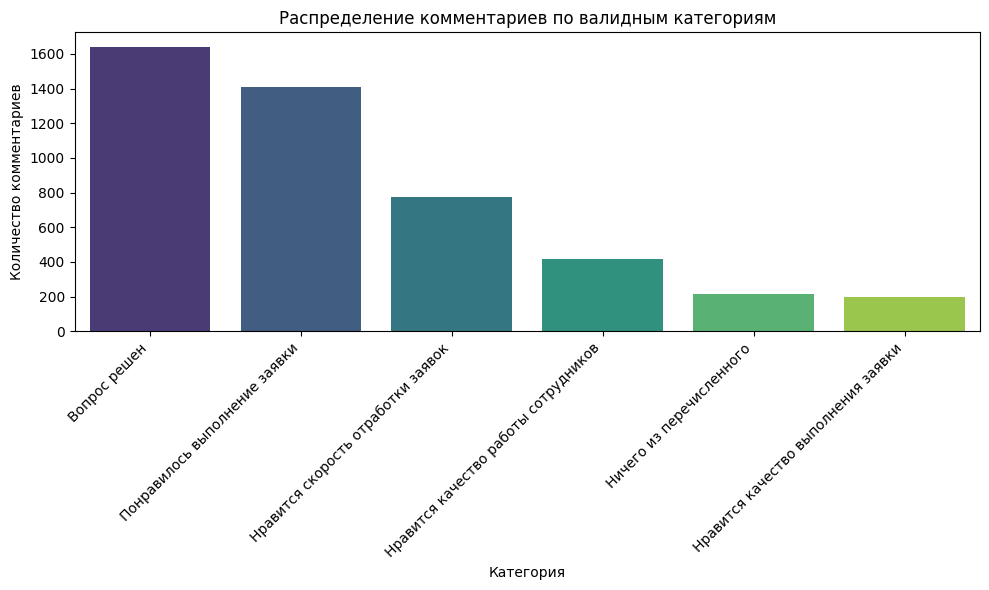

Распределение по валидным категориям:
Вопрос решен                            1642
Понравилось выполнение заявки           1409
Нравится скорость отработки заявок       775
Нравится качество работы сотрудников     417
Ничего из перечисленного                 216
Нравится качество выполнения заявки      199
dtype: int64


In [10]:
initial_category_cols = [
    'Вопрос решен',
    'Нравится качество выполнения заявки',
    'Нравится качество работы сотрудников',
    'Нравится скорость отработки заявок',
    'Понравилось выполнение заявки',
    'Ничего из перечисленного'
 ]

# Фильтрация категорий, имеющих более одного уникального значения (т.е. не только 0 или только 1)
valid_category_cols = []
for col in initial_category_cols:
    if col in df.columns and df[col].nunique() > 1:
        valid_category_cols.append(col)
    else:
        print(f"Категория {col} была исключена, так как содержит только один класс или отсутствует в данных.")

if not valid_category_cols:
    raise ValueError("Нет валидных категорий для обучения после фильтрации. Проверьте данные.")

print(f"Используемые категории для обучения и оценки: {valid_category_cols}")

# Подсчет количества комментариев по валидным категориям
category_counts = df[valid_category_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
plt.title('Распределение комментариев по валидным категориям')
plt.xlabel('Категория')
plt.ylabel('Количество комментариев')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Распределение по валидным категориям:")
print(category_counts)


Предобработка текста комментариев


In [11]:
stop_words_russian = stopwords.words('russian')

def preprocess_text(text):
    text = str(text).lower()  # Приведение к нижнему регистру
    text = re.sub(r'\s+[а-я]{1,2}\s+', ' ', text) # Удаление коротких предлогов/союзов (очень грубо)
    text = re.sub(r'[^а-яА-ЯёЁ0-9\s]', ' ', text)  # Удаление пунктуации и спецсимволов, оставляем только кириллицу, цифры и пробелы
    text = re.sub(r'\s+', ' ', text).strip()  # Удаление лишних пробелов
    tokens = text.split() # Замена word_tokenize для русского языка
    tokens = [word for word in tokens if word not in stop_words_russian and len(word) > 2] # Удаление стоп-слов и коротких слов
    return ' '.join(tokens)

# Применение предобработки к столбцу 'comment'
# Убедимся, что столбец 'comment' существует и не пустой
if 'comment' in df.columns:
    df['processed_comment'] = df['comment'].apply(preprocess_text)
    print("Пример обработанного комментария:")
    if not df.empty and 'comment' in df and 'processed_comment' in df:
        print(f"Оригинал: {df['comment'].iloc[0]}")
        print(f"Обработанный: {df['processed_comment'].iloc[0]}")
        print("Первые 5 строк с обработанными комментариями:")
        print(df[['comment', 'processed_comment']].head())
    else:
        print("DataFrame пуст или отсутствуют необходимые столбцы для вывода примера.")
else:
    print("Столбец 'comment' не найден в DataFrame.")


Пример обработанного комментария:
Оригинал: спасибо
Обработанный: спасибо
Первые 5 строк с обработанными комментариями:
                                        comment  \
0                                       спасибо   
1                                      спасибо!   
2                                      Отлично    
3  Благодарю за оперативное решение проблемы !    
4         Прекрасный специалист! Побольше таких   

                        processed_comment  
0                                 спасибо  
1                                 спасибо  
2                                 отлично  
3  благодарю оперативное решение проблемы  
4    прекрасный специалист побольше таких  


## Разделение данных на признаки (X) и целевые переменные (y)


In [12]:
X = df['processed_comment']
y = df[valid_category_cols] # Используем только валидные категории

print(f"Размер X: {X.shape}")
print(f"Размер y: {y.shape}")


Размер X: (1862,)
Размер y: (1862, 6)


In [26]:
MODEL_NAME = "DeepPavlov/rubert-base-casedв"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Функция для токенизации
def tokenize_function(examples):
    return tokenizer(examples["comment"], padding="max_length", truncation=True, max_length=128)

# Создание Dataset объекта
# Переименовываем колонки с категориями в \"labels\" для Trainer API, если это необходимо, или обрабатываем их в Dataset классе
# Для multi-label, labels должны быть списком списков или np.array float32
df["labels"] = df[valid_category_cols].values.tolist()
full_dataset = Dataset.from_pandas(df[["comment", "labels"]])

# Токенизация всего датасета
tokenized_datasets = full_dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["comment"]) # Удаляем текстовый столбец, он больше не нужен
tokenized_datasets.set_format("torch") # Устанавливаем формат для PyTorch

print("Пример первого элемента датасета после токенизации:")
print(tokenized_datasets[0])

NameError: name 'AutoTokenizer' is not defined